# Hotel Booking Cancellation Prediction #

This project predicts hotel booking cancellations using historical booking data. The data includes various features like lead time,adr stay duration, customer type, and more. The goal is to predict whether a reservation will be canceled.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

**Loading Dataset**

In [2]:
#Load excel workbook
data = pd.ExcelFile('hotel_revenue_historical_full-2.xlsx')

#load data into dataframe
bookings_2018 = data.parse('2018')
bookings_2019 = data.parse('2019')
bookings_2020 = data.parse('2020')
meal_cost = data.parse('meal_cost')
market_segment = data.parse('market_segment')

In [3]:
#merge hotel bookings data
hotel_bookings = pd.concat([bookings_2018, bookings_2019, bookings_2020], ignore_index = True)
#merge 'meal cost' and 'market segment' data with 'hotel bookings' data
hotel_data = hotel_bookings.merge(meal_cost, on = 'meal', how = 'left').merge(market_segment, on = 'market_segment', how = 'left')

**Exploratory Data Analysis & Data Cleaning**

In [4]:
hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Cost,Discount
0,Resort Hotel,1,85,2018,July,27,1,0,3,2,...,NaN,0,Transient,82.0,0,1,Canceled,2018-05-06,12.99,0.3
1,Resort Hotel,1,75,2018,July,27,1,0,3,2,...,NaN,0,Transient,105.5,0,0,Canceled,2018-04-22,17.99,0.3
2,Resort Hotel,1,23,2018,July,27,1,0,4,2,...,NaN,0,Transient,123.0,0,0,Canceled,2018-06-23,12.99,0.3
3,Resort Hotel,1,60,2018,July,27,1,2,5,2,...,NaN,0,Transient,107.0,0,2,Canceled,2018-05-11,12.99,0.3
4,Resort Hotel,1,96,2018,July,27,1,2,8,2,...,NaN,0,Transient,108.3,0,2,Canceled,2018-05-29,12.99,0.1


In [5]:
#define functions for checking data structure
def wrangle(data_name):
    #get the shape of df
    df_shape = data_name.shape
    #get the info of df
    df_info = data_name.info()
    
    return df_shape, df_info

In [6]:
wrangle(hotel_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141947 entries, 0 to 141946
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           141947 non-null  object        
 1   is_canceled                     141947 non-null  int64         
 2   lead_time                       141947 non-null  int64         
 3   arrival_date_year               141947 non-null  int64         
 4   arrival_date_month              141947 non-null  object        
 5   arrival_date_week_number        141947 non-null  int64         
 6   arrival_date_day_of_month       141947 non-null  int64         
 7   stays_in_weekend_nights         141947 non-null  int64         
 8   stays_in_week_nights            141947 non-null  int64         
 9   adults                          141947 non-null  int64         
 10  children                        141939 non-null  float64

((141947, 34), None)

In [7]:
#check missing values
hotel_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               8
babies                                 0
meal                                   0
country                              625
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              19555
company         

In [8]:
#fill missing values for agent and company
hotel_data['agent'].fillna(-1, inplace=True) 
hotel_data['company'].fillna(-1, inplace=True)

In [9]:
#drop missing values for childtren and country
hotel_data.dropna(inplace = True)

In [10]:
#check duplicate
hotel_data.duplicated().sum()

41127

In [11]:
#drop duplicate
hotel_data.drop_duplicates(inplace = True)

In [12]:
#statistical summary
hotel_data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,Cost,Discount
count,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,...,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187.000000,100187,100187.000000,100187.000000
mean,0.266751,77.377344,2019.183816,28.554972,15.786889,1.011668,2.645293,1.872978,0.134259,0.011608,...,0.269845,82.229621,9.603541,0.779353,104.677043,0.085410,0.691707,2019-09-02 16:25:06.303212544,15.673991,0.258469
min,0.000000,0.000000,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00,0.000000,0.100000
25%,0.000000,11.000000,2019.000000,18.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,9.000000,-1.000000,0.000000,70.000000,0.000000,0.000000,2019-04-09 00:00:00,12.990000,0.200000
50%,0.000000,47.000000,2019.000000,30.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,9.000000,-1.000000,0.000000,96.900000,0.000000,0.000000,2019-09-14 00:00:00,12.990000,0.300000
75%,1.000000,119.000000,2020.000000,39.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,...,0.000000,240.000000,-1.000000,0.000000,132.000000,0.000000,1.000000,2020-02-10 00:00:00,12.990000,0.300000
max,1.000000,737.000000,2020.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,...,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2020-09-14 00:00:00,35.000000,1.000000
std,0.442263,84.763413,0.643070,13.714294,8.799421,1.031859,2.055878,0.696902,0.450636,0.118864,...,0.719191,109.871586,52.601542,9.878765,54.259768,0.282936,0.830821,NaN,6.671815,0.107434


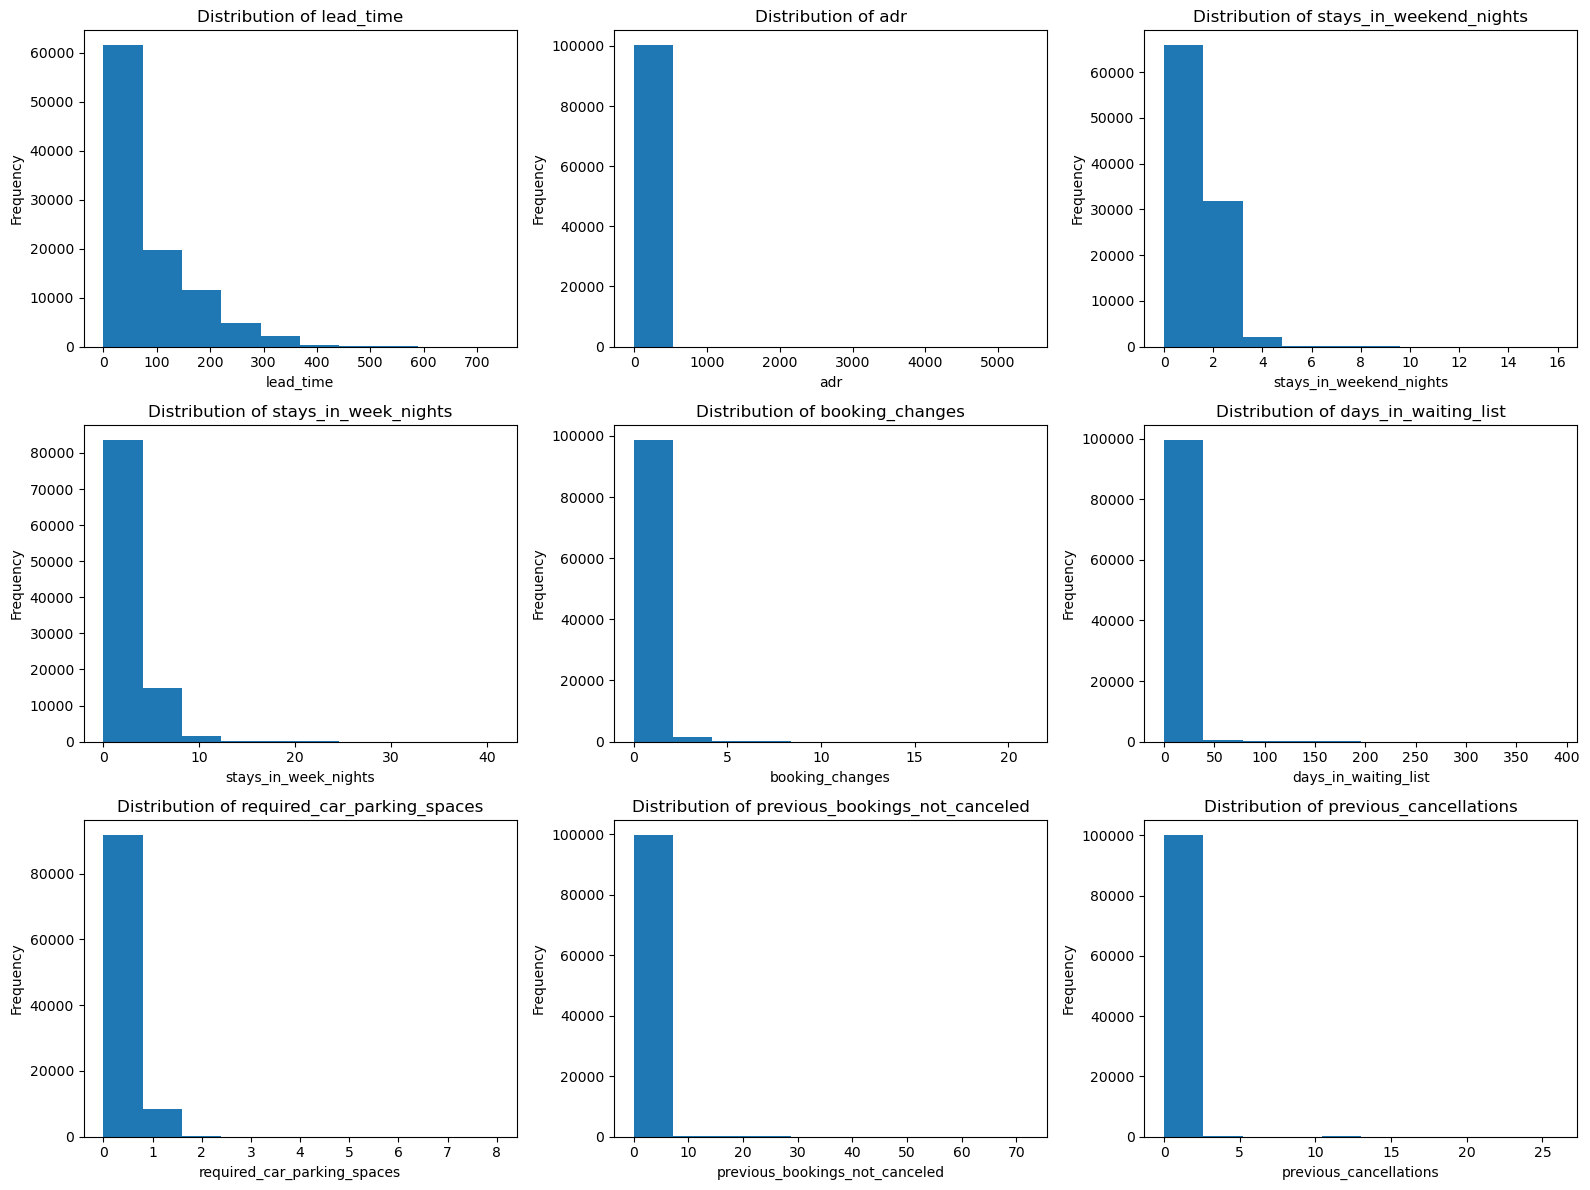

In [13]:
#plotting histogram to check for outliers
columns_to_plot = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'previous_bookings_not_canceled', 'previous_cancellations']

plt.figure(figsize =(16, 12))

for i, column in enumerate(columns_to_plot):
    plt.subplot(3,3, i + 1)
    plt.hist(hotel_data[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout();

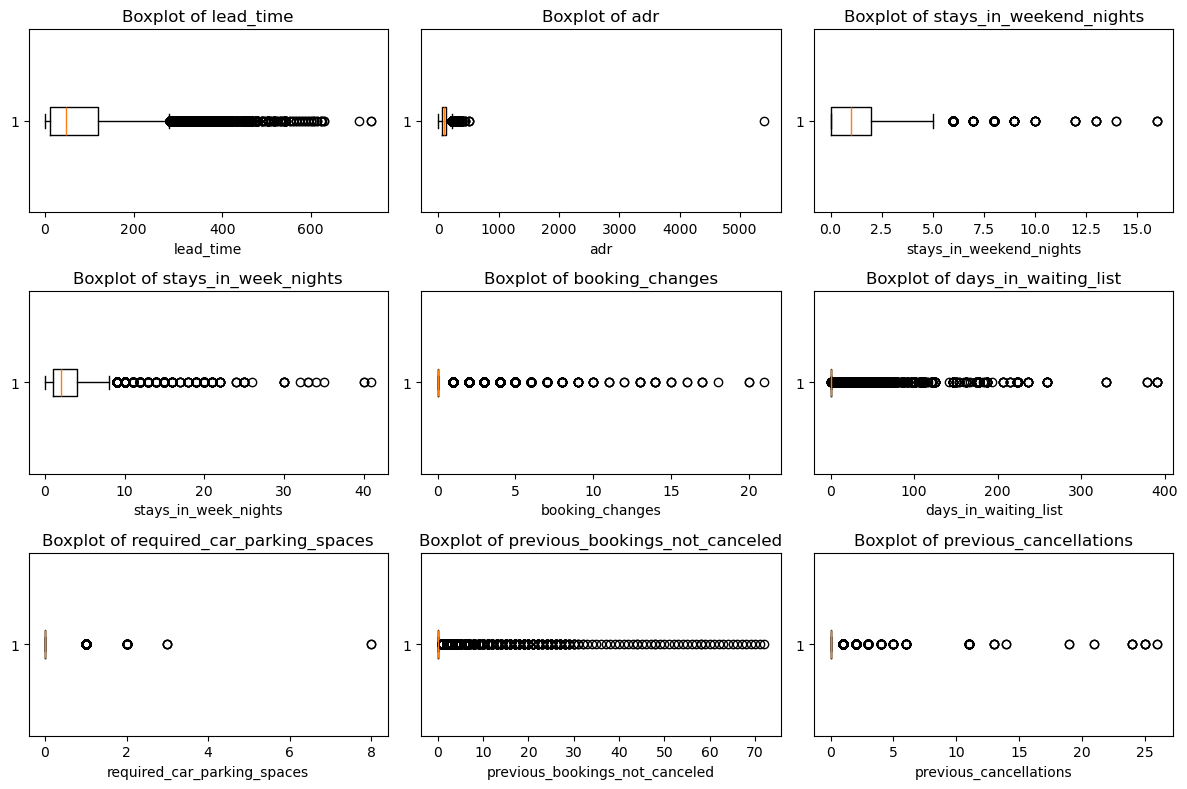

In [14]:
#plotting boxplot to check the extent of outlier
columns_to_plot = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'previous_bookings_not_canceled', 'previous_cancellations']
plt.figure(figsize = (12,8))
for i, col in enumerate(columns_to_plot):
    plt.subplot(3, 3, i+1)
    plt.boxplot(hotel_data[col], vert = False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout();

In [15]:
#Remove outliers and assign a new df

#functions to remove outliers
def remove_outiers_with_IQR(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    #functions to mask outliers
    mask_outliers = ((df[columns] >= (Q1 - 1.5 * IQR)) & (df[columns] <= (Q3 + 1.5 *IQR))).all(axis = 1)
    #return df ith no outliers
    return df[mask_outliers]

#columns to remove outliers from
columns_to_remove_outliers = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights']

#remove outliers and assign a new df
df = remove_outiers_with_IQR(hotel_data, columns_to_remove_outliers)

wrangle(df)

<class 'pandas.core.frame.DataFrame'>
Index: 92554 entries, 0 to 141946
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           92554 non-null  object        
 1   is_canceled                     92554 non-null  int64         
 2   lead_time                       92554 non-null  int64         
 3   arrival_date_year               92554 non-null  int64         
 4   arrival_date_month              92554 non-null  object        
 5   arrival_date_week_number        92554 non-null  int64         
 6   arrival_date_day_of_month       92554 non-null  int64         
 7   stays_in_weekend_nights         92554 non-null  int64         
 8   stays_in_week_nights            92554 non-null  int64         
 9   adults                          92554 non-null  int64         
 10  children                        92554 non-null  float64       
 11  babies

((92554, 34), None)

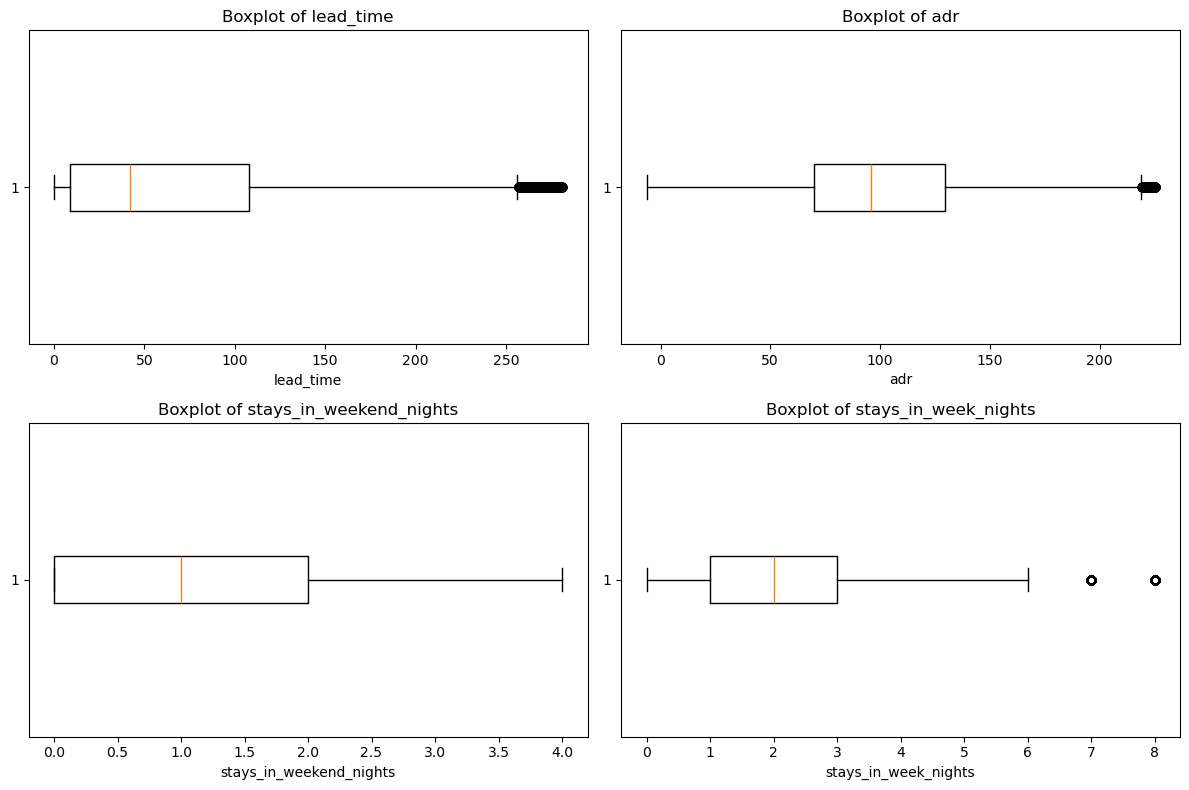

In [16]:
#plotting boxplot to check the result

columns = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights']

plt.figure(figsize = (12,8))
for i, col in enumerate(columns):
    plt.subplot(2, 2, i+1)
    plt.boxplot(df[col], vert = False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout();

In [17]:
#statistical summary
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,Cost,Discount
count,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,...,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554.000000,92554,92554.000000,92554.000000
mean,0.255883,67.513214,2019.168475,28.382663,15.812445,0.939603,2.447188,1.856830,0.115122,0.011388,...,0.255537,78.614722,9.581380,0.595717,100.956986,0.085291,0.690916,2019-08-29 09:36:37.713767168,15.731718,0.259895
min,0.000000,0.000000,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00,0.000000,0.100000
25%,0.000000,9.000000,2019.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,9.000000,-1.000000,0.000000,70.000000,0.000000,0.000000,2019-04-04 00:00:00,12.990000,0.300000
50%,0.000000,42.000000,2019.000000,29.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,9.000000,-1.000000,0.000000,96.000000,0.000000,0.000000,2019-09-11 00:00:00,12.990000,0.300000
75%,1.000000,108.000000,2020.000000,40.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,195.000000,-1.000000,0.000000,129.622500,0.000000,1.000000,2020-02-02 00:00:00,12.990000,0.300000
max,1.000000,281.000000,2020.000000,53.000000,31.000000,4.000000,8.000000,4.000000,3.000000,10.000000,...,17.000000,535.000000,543.000000,224.000000,225.000000,8.000000,5.000000,2020-09-10 00:00:00,35.000000,1.000000
std,0.436359,69.801268,0.640087,13.963197,8.813208,0.910257,1.637355,0.505027,0.411397,0.118516,...,0.675894,108.183483,52.831174,7.498489,45.267434,0.282699,0.825963,NaN,6.817673,0.108401


In [18]:
#categorical summary
df.describe(include = 'object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,92554,92554,92554,92554,92554,92554,92554,92554,92554,92554,92554
unique,2,12,5,174,7,5,10,12,3,4,3
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,57145,11429,73189,31681,53564,72908,61920,49925,91587,74883,68917


In [19]:
#print categorical report
for col in df.describe(include = 'object').columns:
    print (col)
    print(df[col].unique())
    print('.' * 60)

hotel
['Resort Hotel' 'City Hotel']
............................................................
arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
............................................................
meal
['BB' 'HB' 'FB' 'Undefined' 'SC']
............................................................
country
['PRT' 'IRL' 'ESP' 'DEU' 'CN' 'ITA' 'GBR' 'BEL' 'RUS' 'FRA' 'MOZ' 'IRN'
 'BRA' 'KOR' 'AGO' 'USA' 'ROU' 'NOR' 'ARG' 'POL' 'CHE' 'GRC' 'NLD' 'DNK'
 'SWE' 'AUS' 'EST' 'CZE' 'FIN' 'BWA' 'LUX' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR'
 'SMR' 'LVA' 'PRI' 'SRB' 'IND' 'CHL' 'AUT' 'LTU' 'OMN' 'TUR' 'ZAF' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'CRI' 'NZL' 'HUN' 'HRV' 'KAZ' 'THA' 'COL'
 'DOM' 'MKD' 'MYS' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'TUN' 'STP'
 'BGR' 'TWN' 'AZE' 'IDN' 'LBN' 'SVK' 'CMR' 'SGP' 'SEN' 'PER' 'EGY' 'SAU'
 'KNA' 'JOR' 'KWT' 'ETH' 'PHL' 'LIE' 'MMR' 'IRQ' 'PAN' 'GEO' 'TMP' 'MUS'
 'ECU' 'ARE' 'HKG' 

In [20]:
#print numerical report
for col in df.describe().columns:
    print (col)
    print(df[col].unique())
    print('.' * 60)

is_canceled
[1 0]
............................................................
lead_time
[ 85  75  23  60  96  45  40  43  47   3  71  63  62 101  51  48  81 109
  72  26  73 102  33   5  34  93  86  94  67  88 113 105   1 280  77  24
  44  17 103  69 100  36  59  58  97  79  42  98  95  76 112  39  57  66
   0  10  12  35  15   7  32  37 123  38  31 104 118  41  52  49  55  19
  53  16  54  87  29  25 107  50 116  74  11  70 119   8  30  65  64   4
  83  56  18 136  84  89  80   9 124  82  91 130   2  13 131  61 114 111
 117  46 122 106  78 137 129  68 139 120  27  22 128 143  99 151 132 126
 110 157 108 147  21 156 127 164 159  14 161 149  28 155 142  90  20 148
 172 171 145 121 178 175 158 185 183   6 115 192 170 134  92 125 165 241
 193 235 133 209 238 215 160 202 259 261 195 187 275 231 236 179 267 210
 211 181 200 182 184 252 213 173 135 217 222 207 268 140 141 191 265 180
 237 228 146 177 226 234 270 216 256 150 169 166 244 203 212 250 198 277
 152 144 167 214 242 253 260 274 19

**DATA ANALYSIS AND VISUALIZATION**

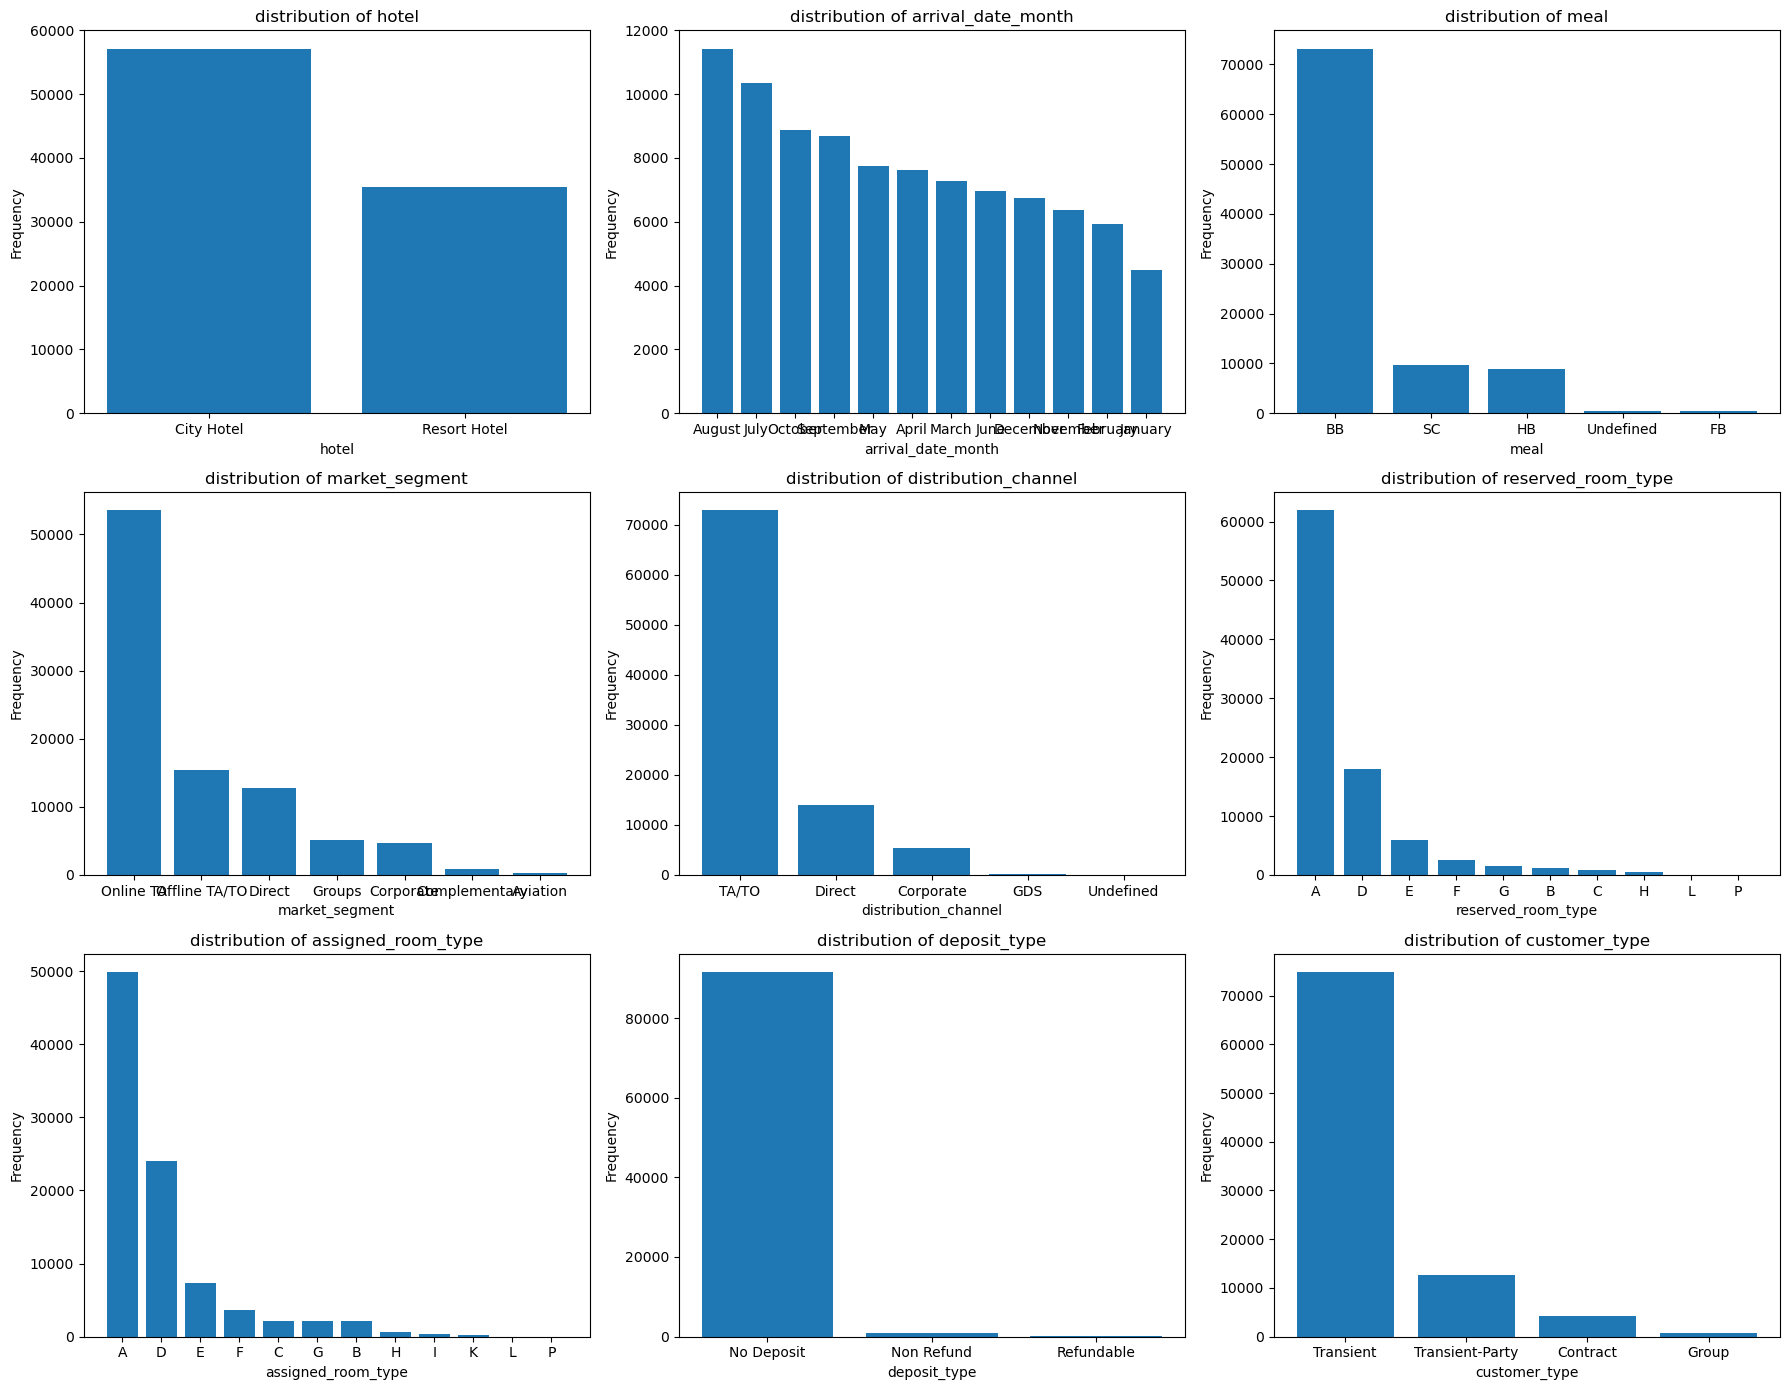

In [21]:
#plot bar for distribution of categorical column 
categorical_data = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type','assigned_room_type','deposit_type', 
                    'customer_type']

plt.figure(figsize = (18,14))
for i, data in enumerate(categorical_data):   
    plt.subplot(3, 3, i+1)
    plt.bar(x = df[data].value_counts().index, height = df[data].value_counts().values)
    plt.title(f'distribution of {data}')
    plt.xlabel(data) 
    plt.ylabel('Frequency') 
    plt.xticks()
plt.tight_layout();

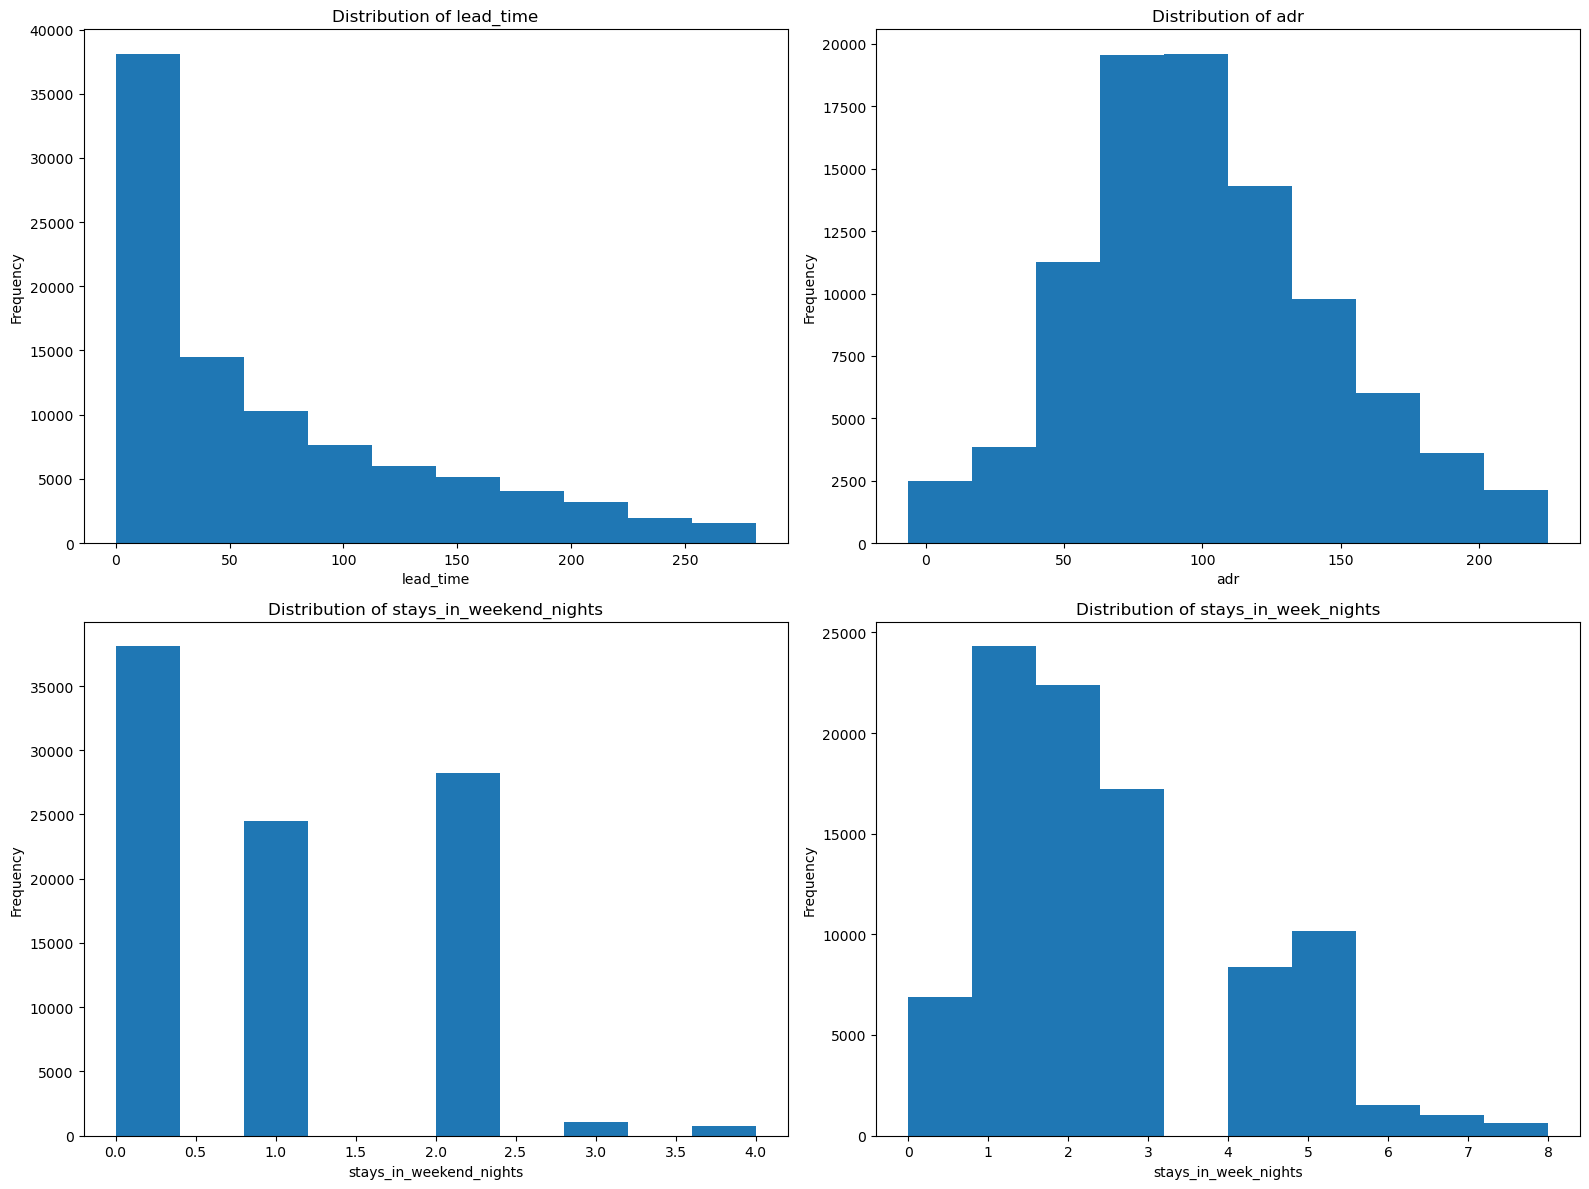

In [22]:
#plot  histogram with matplotlib
columns_to_plot = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights']
plt.figure(figsize =(16, 12))

for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.hist(df[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout();

is_canceled
0    68871
1    23683
Name: count, dtype: int64


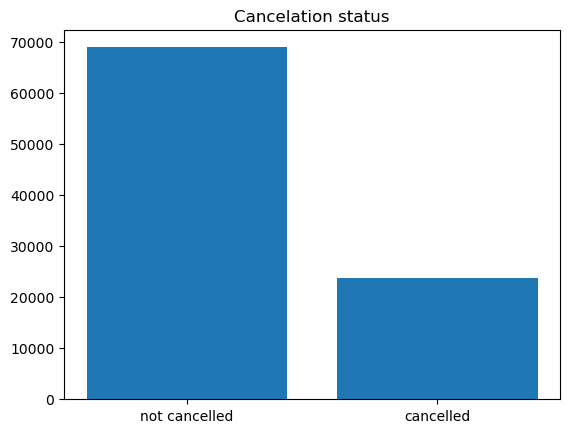

In [23]:
#print the cancelation value counts and plot bar to visualize
print(df['is_canceled'].value_counts())

plt.bar(x = ['not cancelled', 'cancelled'], height = df['is_canceled'].value_counts())
plt.title('Cancelation status');

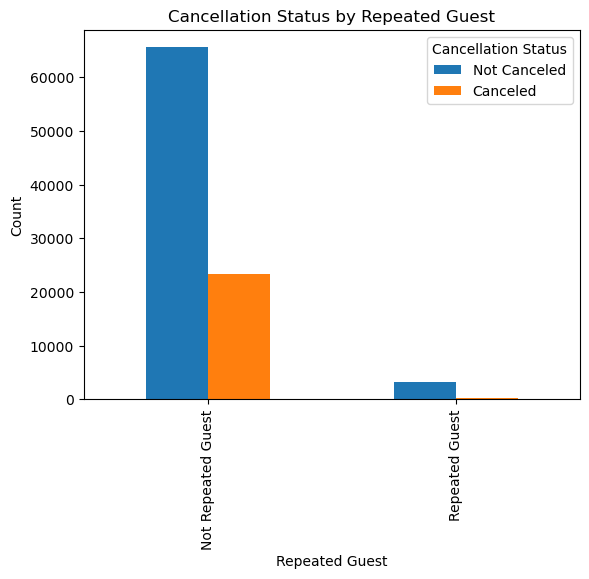

In [24]:
# cancellation status by repeated guest
grouped_data = df.groupby(['is_repeated_guest', 'is_canceled']).size().unstack()
grouped_data.plot(kind='bar', stacked=False)
plt.xlabel('Repeated Guest')
plt.ylabel('Count')
plt.title('Cancellation Status by Repeated Guest')
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.xticks([0, 1], ['Not Repeated Guest', 'Repeated Guest']);

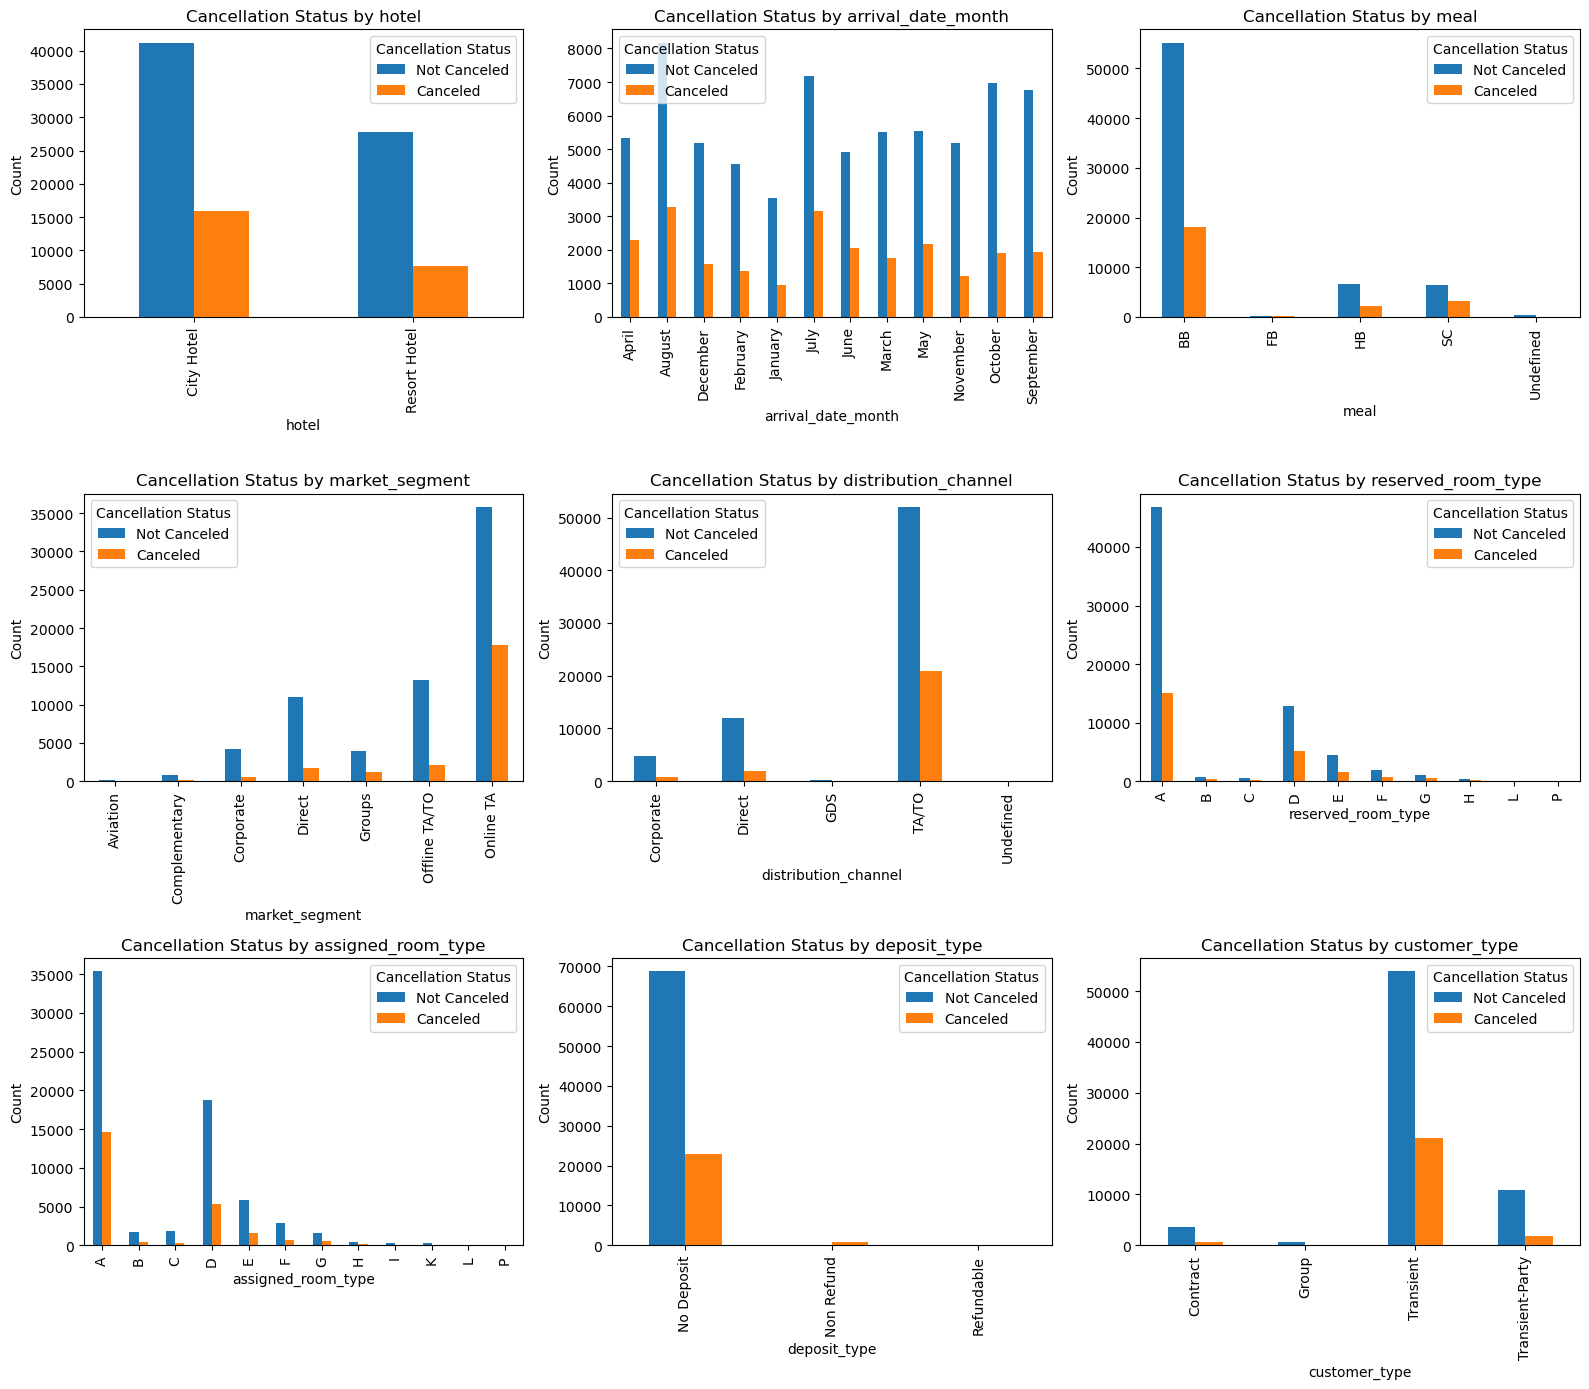

In [25]:
to_plot = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type','assigned_room_type','deposit_type', 
                    'customer_type']
plt.figure(figsize = (16, 14))
for i, to_ in enumerate(to_plot):
    plt.subplot(3, 3, i+1)
    grouped_data = df.groupby([to_, 'is_canceled']).size().unstack()
    grouped_data.plot(kind='bar', stacked=False, ax=plt.gca())
    plt.xlabel(to_)
    plt.ylabel('Count')
    plt.title(f'Cancellation Status by {to_}')
    plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
    plt.tight_layout();

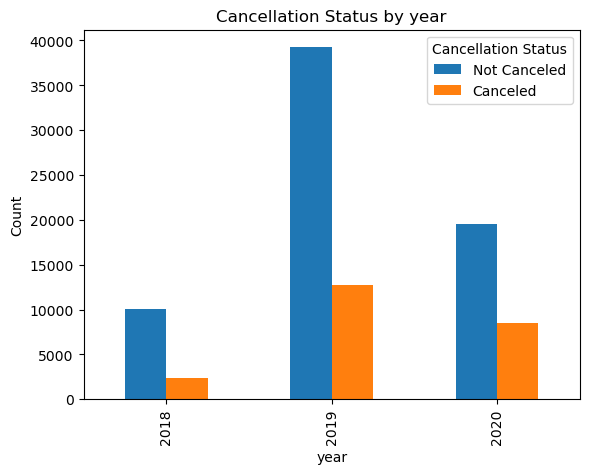

In [26]:
# cancellation status by year
grouped_data = df.groupby(['arrival_date_year', 'is_canceled']).size().unstack()
grouped_data.plot(kind='bar', stacked=False)
plt.xlabel('year')
plt.ylabel('Count')
plt.title('Cancellation Status by year')
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled']);

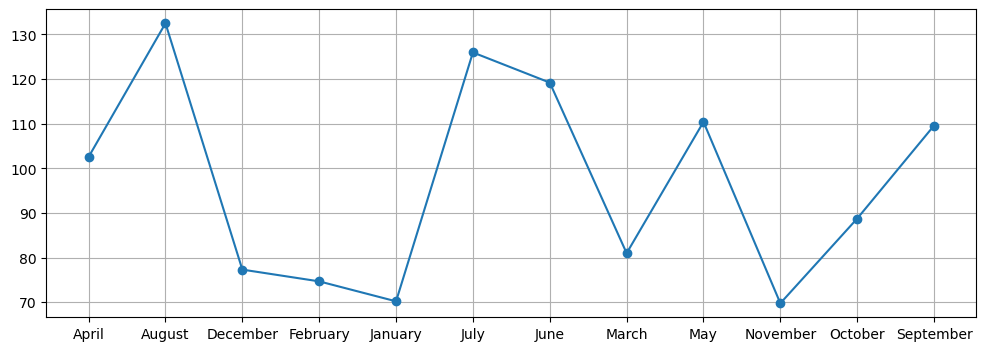

In [27]:
#adr per month
plt.figure(figsize = (12, 4))
adr_per_month = df.groupby('arrival_date_month')['adr'].mean()
plt.grid()
plt.plot(adr_per_month.index, adr_per_month.values, marker='o');

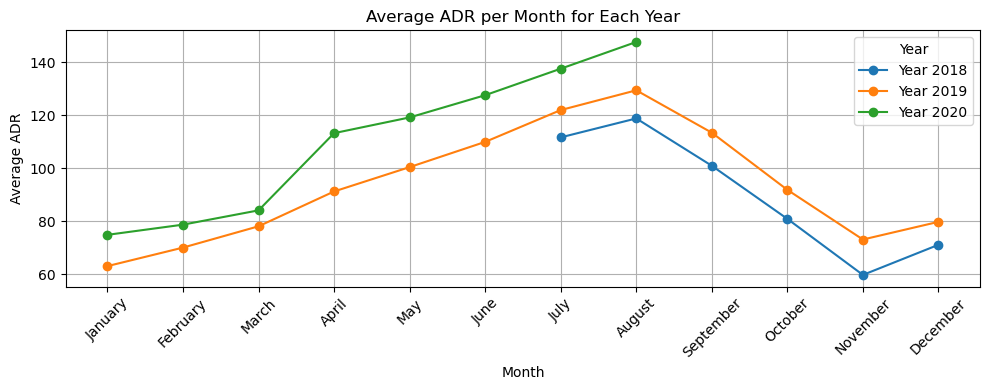

In [28]:
#adr per year
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

adr_per_month_year = df.groupby(['arrival_date_year', 'arrival_date_month'])['adr'].mean().unstack()
adr_per_month_year = adr_per_month_year.reindex(month_order, axis=1)
plt.figure(figsize=(10, 4))
for year in adr_per_month_year.index:
    plt.plot(adr_per_month_year.columns, adr_per_month_year.loc[year], marker='o', label=f'Year {year}')
plt.xlabel('Month')
plt.ylabel('Average ADR')
plt.title('Average ADR per Month for Each Year')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid()
plt.tight_layout();

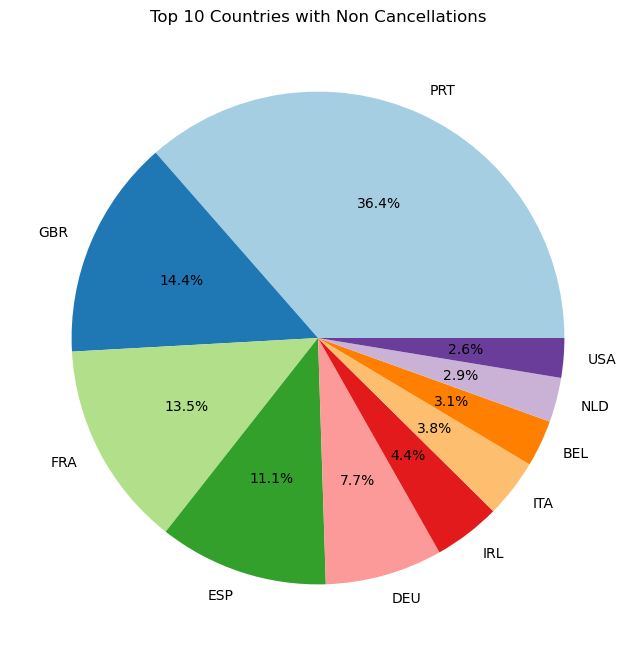

In [29]:
#Top 10 counties with [0] (not canceled) cancelation status

# Filter for not canceled bookings
canceled_data = df[df['is_canceled'] == 0]

country_cancellation_counts = canceled_data['country'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(country_cancellation_counts, labels=country_cancellation_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Top 10 Countries with Non Cancellations');

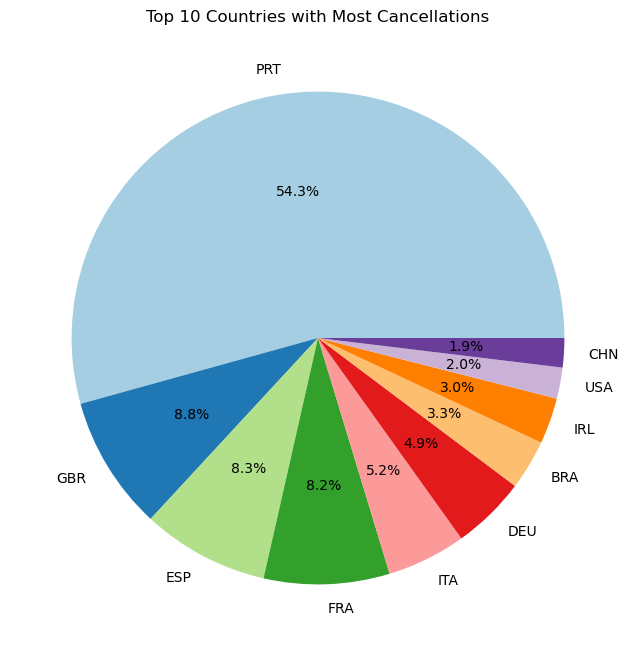

In [30]:
#Top 10 counties with [1] (canceled) cancelation status
# Filter for canceled bookings (is_canceled = 1)
canceled_data = df[df['is_canceled'] == 1]

country_cancellation_counts = canceled_data['country'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(country_cancellation_counts, labels=country_cancellation_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Top 10 Countries with Most Cancellations');

    Cost  total_bookings  total_cancellations  cancellation_rate
0   0.00             468                   72           0.153846
1  12.99           73189                18088           0.247141
2  17.99            8884                 2190           0.246511
3  21.99             382                  102           0.267016
4  35.00            9631                 3231           0.335479


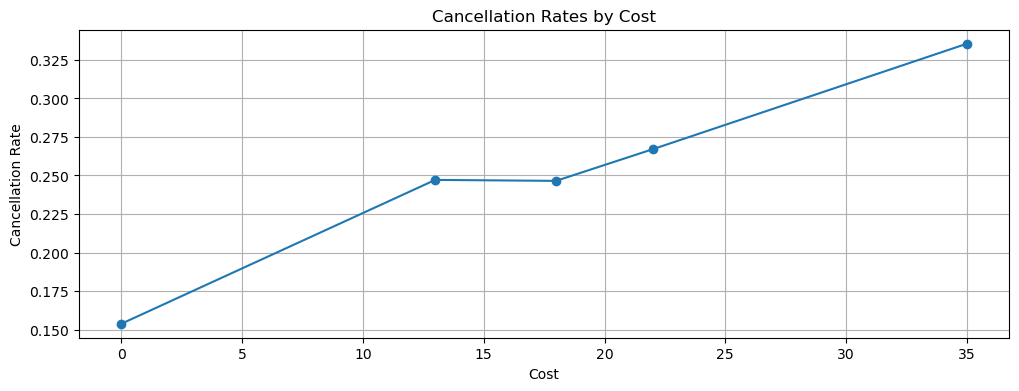

In [31]:
# Calculate cancellation rates by meal cost
cancellation_rate_Meal_Cost = df.groupby('Cost').agg(total_bookings=('is_canceled', 'count'),total_cancellations=('is_canceled', 'sum')).reset_index()

cancellation_rate_Meal_Cost['cancellation_rate'] = cancellation_rate_Meal_Cost['total_cancellations'] / cancellation_rate_Meal_Cost['total_bookings']
print(cancellation_rate_Meal_Cost)

# Visualization
plt.figure(figsize=(12, 4))
plt.plot(cancellation_rate_Meal_Cost['Cost'], cancellation_rate_Meal_Cost['cancellation_rate'], marker='o')
plt.title('Cancellation Rates by Cost')
plt.xlabel('Cost')
plt.ylabel('Cancellation Rate')
plt.grid()
plt.show()

* Correlation Analysis

In [32]:
corr_columns = df[['lead_time', 'adr', 'is_canceled', 'stays_in_weekend_nights', 'stays_in_week_nights', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 
                   'previous_bookings_not_canceled','previous_cancellations', 'adults', 'children', 'babies', 'is_repeated_guest', 'agent', 'company', 'total_of_special_requests',
                   'Cost', 'Discount']]

matrix =  corr_columns.corr()
matrix

,lead_time,adr,is_canceled,stays_in_weekend_nights,stays_in_week_nights,booking_changes,days_in_waiting_list,required_car_parking_spaces,previous_bookings_not_canceled,previous_cancellations,adults,children,babies,is_repeated_guest,agent,company,total_of_special_requests,Cost,Discount
lead_time,1.000000,0.075565,0.190563,0.248021,0.343904,0.060551,0.104495,-0.085541,-0.079113,0.021750,0.182087,0.035320,-0.002603,-0.155839,0.068812,-0.099985,0.052449,-0.006644,0.057267
adr,0.075565,1.000000,0.129870,0.067277,0.100088,-0.001757,-0.030344,0.026111,-0.090523,-0.050316,0.329748,0.256295,0.015955,-0.178362,-0.047196,-0.144237,0.151695,0.012659,-0.057444
is_canceled,0.190563,0.129870,1.000000,0.051205,0.081454,-0.087955,0.000940,-0.176921,-0.047092,0.075582,0.086227,0.051615,-0.017069,-0.075771,-0.005385,-0.064709,-0.098957,0.062159,0.074819
stays_in_weekend_nights,0.248021,0.067277,0.051205,1.000000,0.379976,0.017710,-0.042876,-0.039394,-0.055535,-0.015818,0.127875,0.028406,0.019296,-0.118579,0.143520,-0.098740,0.039494,-0.028806,0.039416
stays_in_week_nights,0.343904,0.100088,0.081454,0.379976,1.000000,0.052531,0.007419,-0.040478,-0.062734,-0.011433,0.156556,0.037104,0.022865,-0.136604,0.193434,-0.077961,0.057464,-0.053778,0.050900
booking_changes,0.060551,-0.001757,-0.087955,0.017710,0.052531,1.000000,0.042082,0.046074,0.007761,-0.012671,-0.056339,0.040227,0.075893,0.006028,0.016343,0.086635,0.006932,-0.030135,-0.102931
days_in_waiting_list,0.104495,-0.030344,0.000940,-0.042876,0.007419,0.042082,1.000000,-0.016543,-0.006483,0.003414,-0.030746,-0.018953,-0.007622,-0.013626,-0.010761,-0.007164,-0.056725,-0.028461,-0.039249
required_car_parking_spaces,-0.085541,0.026111,-0.176921,-0.039394,-0.040478,0.046074,-0.016543,1.000000,0.036709,-0.009081,0.015453,0.034302,0.026800,0.061934,0.131477,0.031902,0.046870,-0.062160,-0.064544
previous_bookings_not_canceled,-0.079113,-0.090523,-0.047092,-0.055535,-0.062734,0.007761,-0.006483,0.036709,1.000000,0.335040,-0.141063,-0.025607,-0.008897,0.441729,-0.055510,0.125591,0.023911,-0.035107,-0.010212
previous_cancellations,0.021750,-0.050316,0.075582,-0.015818,-0.011433,-0.012671,0.003414,-0.009081,0.335040,1.000000,-0.039948,-0.016559,-0.004605,0.180140,-0.025575,0.022177,-0.000683,-0.013624,-0.006436


**Model Development**

In [33]:
#create a new df and keep the original df intact
df_encode = df.copy()

In [34]:
#encoding categorical data
cat_data = ['hotel', 'arrival_date_month', 'country', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type','assigned_room_type','deposit_type', 'customer_type']

df_encode = pd.get_dummies(df_encode, columns = cat_data, drop_first = True)

In [35]:
#feature selection: x for independent variable (features), y for dependent variable(target)
x = df_encode.drop(columns = ['is_canceled', 'reservation_status_date', 'arrival_date_year', 'reservation_status'])

y = df_encode['is_canceled']

In [36]:
#spliting dataset into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 42)

- Model Selection - Logistic Regression (1)

In [37]:
#model selection
model = LogisticRegression()
model

#fitting model
model.fit(x_train, y_train)

LogisticRegression()

In [38]:
#predicting model
y_pred = model.predict(x_test)

In [39]:
accuracy_score(y_test, y_pred)

0.7844923830446213

In [40]:
confusion_matrix(y_test, y_pred)

array([[18958,  1698],
       [ 4286,  2825]], dtype=int64)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86     20656
           1       0.62      0.40      0.49      7111

    accuracy                           0.78     27767
   macro avg       0.72      0.66      0.67     27767
weighted avg       0.77      0.78      0.77     27767



- Model Selection - Decision Tree Calssifier (2)

In [42]:
model2 = DecisionTreeClassifier(random_state = 42)
model2

model2.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [43]:
y_pred2 = model2.predict(x_test)

In [44]:
accuracy_score(y_test, y_pred2)

0.8224871250045017

In [45]:
confusion_matrix(y_test, y_pred2)

array([[18121,  2535],
       [ 2394,  4717]], dtype=int64)

In [46]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     20656
           1       0.65      0.66      0.66      7111

    accuracy                           0.82     27767
   macro avg       0.77      0.77      0.77     27767
weighted avg       0.82      0.82      0.82     27767



- Model Selection - RandomForestClassifier (3)

In [47]:
model3 = RandomForestClassifier(n_estimators=100)
model3

model3.fit(x_train, y_train)

RandomForestClassifier()

In [49]:
y_pred3 = model3.predict(x_test)

In [50]:
accuracy_score(y_test, y_pred3)

0.86534375337631

In [51]:
confusion_matrix(y_test, y_pred3)

array([[19510,  1146],
       [ 2593,  4518]], dtype=int64)

In [52]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     20656
           1       0.80      0.64      0.71      7111

    accuracy                           0.87     27767
   macro avg       0.84      0.79      0.81     27767
weighted avg       0.86      0.87      0.86     27767



**Feature Importance From Random Forest Classifier**

In [53]:
importances = model3.feature_importances_

#Create a DataFrame for features and their importances
feature_importance_df = pd.DataFrame({ 'Feature': x_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

                    Group  Importance
13                country    0.130393
20                   lead    0.129975
2                     adr    0.090809
5     arrival_date_day_of    0.070417
7       arrival_date_week    0.062921
6      arrival_date_month    0.058540
29       total_of_special    0.057633
4                   agent    0.048794
27          stays_in_week    0.047177
21         market_segment    0.037492
28       stays_in_weekend    0.030418
8      assigned_room_type    0.030009
25   required_car_parking    0.025337
23               previous    0.023631
14          customer_type    0.022146
26     reserved_room_type    0.019732
10                booking    0.017214
3                  adults    0.016455
16           deposit_type    0.012074
22                   meal    0.010412
17   distribution_channel    0.010015
0                    Cost    0.009719
18                  hotel    0.009144
11               children    0.008560
1                Discount    0.006176
12          

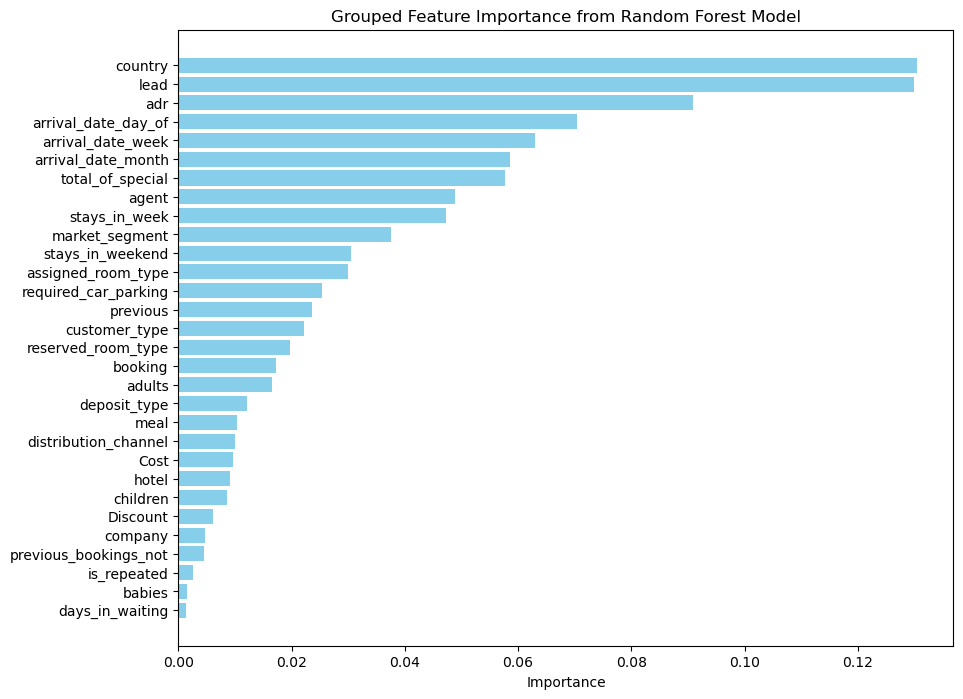

In [54]:
feature_importance_df['Group'] = feature_importance_df['Feature'].apply(lambda x: '_'.join(x.split('_')[:-1]) if '_' in x else x)

# Step 2: Group by the new column and sum the importances
grouped_importance = feature_importance_df.groupby('Group')['Importance'].sum().reset_index()

# Step 3: Sort values for better visualization
grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)

# Display the result
print(grouped_importance)

# Plot the grouped feature importances
plt.figure(figsize=(10, 8))
plt.barh(grouped_importance['Group'], grouped_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Grouped Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [61]:
a = 'Ara'

In [62]:
type(a)

str